Step 1: Imports

In [1]:
!pip install nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.6/22.6 MB 33.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 14.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1 -> 23.2
[notice] To update, run: pip install --upgrade pip


In [4]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
    
print('Using TensorFlow version', tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.9/336.9 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1 -> 23.2
[notice] To update, run: pip install --upgrade pip
Using TensorFlow version 2.12.0


Step 2: Fetching the data

In [18]:
# Issue with dataset, so, downloading from a different source
# link to the thread: https://github.com/dair-ai/emotion_dataset/issues/5
# Dataset details are present here: https://huggingface.co/datasets/dair-ai/emotion

!pip install datasets
from datasets import load_dataset

dataset = load_dataset('emotion')


[notice] A new release of pip is available: 23.1 -> 23.2
[notice] To update, run: pip install --upgrade pip


No config specified, defaulting to: emotion/split
Found cached dataset emotion (/Users/ankit/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 731.69it/s]


In [19]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [58]:
train = dataset['train']

tweets = train['text']
labels = train['label']

print(tweets[:5])
print(labels[:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']
[0, 0, 3, 2, 3]


In [29]:
# from the dataset, https://huggingface.co/datasets/dair-ai/emotion
# we know, 0: sadness, 1:joy, 2:love, 3:anger, 4:fear, 5:surprise

Step 3: Tokenizer

In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [31]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [34]:
# testing the tokenizer

tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

Step 4: Padding and Truncating Sequences

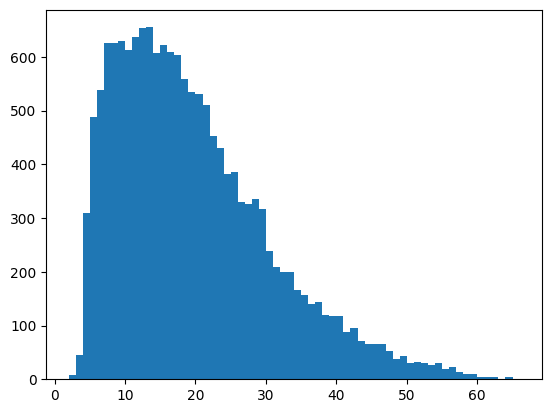

In [52]:
# Let's check the length of the tweets

lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [53]:
# For our model to run, we need to have same length for all the sequences

maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [54]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post',maxlen=maxlen)
    return padded

In [88]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [89]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

Step 5: Labels

In [90]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


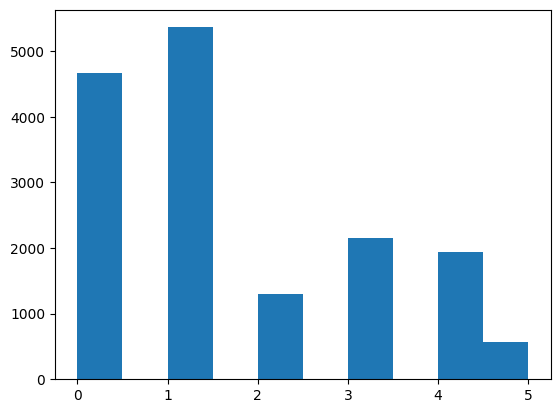

In [91]:
plt.hist(labels)
plt.show()

In [92]:
# Class imbalance problem above, since some have a lot of examples, while others have comparitively less
# Not solving this in the current notebook

In [93]:
index_to_class = {0: 'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
class_to_index = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

Step 5: Creating the model

In [103]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']  
)

In [104]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


Step 6: Train the model

In [105]:
# Let's prepare the validation set

val = dataset['validation']

val_tweets = val['text']
val_labels = val['label']

val_seq = get_sequences(tokenizer, val_tweets)

In [107]:
train_labels = np.array(labels)
val_labels = np.array(val_labels)
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs = 20,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2)
    ]
)

Epoch 1/20
500/500 [==============================] - 8s 16ms/step - loss: 0.5935 - accuracy: 0.7986 - val_loss: 0.5362 - val_accuracy: 0.8245
Epoch 2/20
500/500 [==============================] - 9s 17ms/step - loss: 0.3239 - accuracy: 0.8944 - val_loss: 0.4563 - val_accuracy: 0.8585
Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2155 - accuracy: 0.9339 - val_loss: 0.3960 - val_accuracy: 0.8810
Epoch 4/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1579 - accuracy: 0.9498 - val_loss: 0.3646 - val_accuracy: 0.8835
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1171 - accuracy: 0.9636 - val_loss: 0.3815 - val_accuracy: 0.8855
Epoch 6/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1068 - accuracy: 0.9671 - val_loss: 0.3695 - val_accuracy: 0.8945
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0893 - accuracy: 0.9727 - val_loss: 0.3743 - val_accuracy: 0.9005

Step 7: Evaluating the model

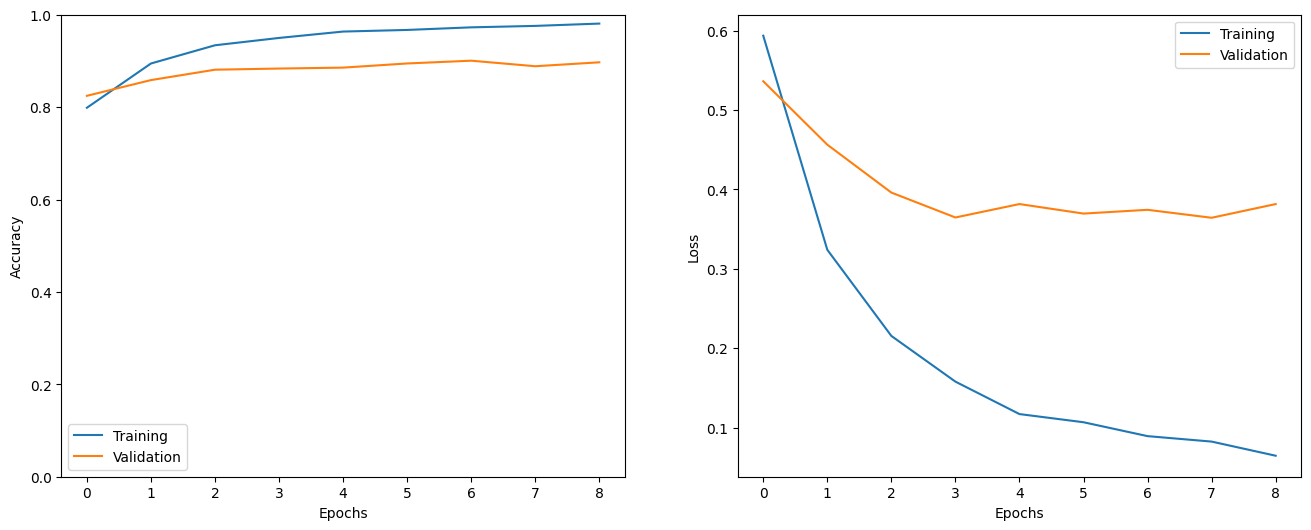

In [108]:
# Let's visualise the training history

show_history(h)

In [110]:
# Prepare the test set

test = dataset['test']

test_tweets = test['text']
test_labels = test['label']

test_seq = get_sequences(tokenizer, test_tweets)
test_labels = np.array(test_labels)

In [111]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 4ms/step - loss: 0.4117 - accuracy: 0.8895


In [132]:
# Let's check at individual predictions on the test set

i = random.randint(0, len(test_labels) - 1)

print(test_tweets[i])
print(test_labels[i])
print(index_to_class[test_labels[i]])

pred = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(pred).astype('uint8')]
print(pred_class)

i breathe into the feelings in my body resisting my mind s clever attempts to analyse what i m feeling
1
joy
1/1 [==============================] - 0s 14ms/step
joy


63/63 [==============================] - 0s 4ms/step


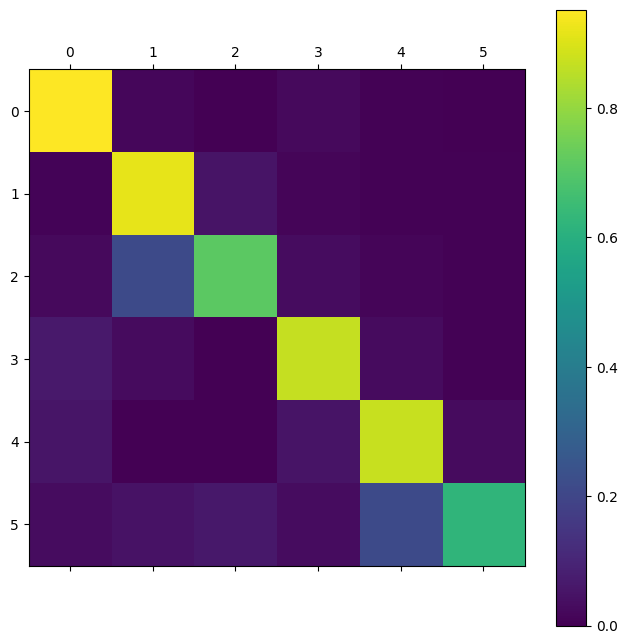

In [138]:
# Let's have all the predictions on the test set

all_preds = model.predict(test_seq)
pred_classes=np.argmax(all_preds,axis=1)


show_confusion_matrix(test_labels, pred_classes, list(classes))